# Foundations of AI/ML by IIIT-Hyderabad & Talent Sprint
# Lab04 Experiment 3

# SPEECH RECOGNITION

Speech has been one of the most widely used mode of communication. One of the part of our day-today communication is to give and receive commands/instructions. Making a machine understand these instructions to perform certain activities can be a boon for a host of applications.

In this experiment we will work on recognizing speech into 30 commands.

- Firstly, we will explore and visualize audio features for speech.


- We will then use these features to train different classifiers, to classify them into 30 different classes:
    - kNN classifier with MFCC features
    - kNN classifier with Deep features
    - Naive Bayes classifier with MFCC features
    - Naive Bayes classifier with Deep features
    - Multi-class linear classifier with MFCC features
    - Multi-class linear classifier with Deep features


- Lastly, we will use different evaluation measures to compare the performances of our classifiers.

In [1]:
!pip install librosa      #required library for experiment


    100% |################################| 1.5MB 1.1MB/s eta 0:00:01
    100% |################################| 184kB 7.6MB/s eta 0:00:01
    100% |################################| 327kB 5.0MB/s eta 0:00:01
    100% |################################| 1.9MB 907kB/s eta 0:00:01
    100% |################################| 14.8MB 117kB/s eta 0:00:01   18% |#####                           | 2.8MB 25.6MB/s eta 0:00:01    30% |#########                       | 4.5MB 39.7MB/s eta 0:00:01    48% |###############                 | 7.2MB 66.7MB/s eta 0:00:01
  Running setup.py bdist_wheel for librosa ... done
  Stored in directory: /root/.cache/pip/wheels/7a/bf/9f/fc279e1814da2144161848a7419cdcf923d0c03f481abe7904
  Running setup.py bdist_wheel for audioread ... done
  Stored in directory: /root/.cache/pip/wheels/47/cc/d8/e1476000d1720a72117ef5c0b1a51388b8567ebfface47ede7
  Running setup.py bdist_wheel for resampy ... done
  Stored in directory: /root/.cache/pip/wheels/c6/8e/c0/4c402972789ddf6

In [2]:
import os

import warnings
warnings.filterwarnings("ignore")

# Math
import numpy as np
from scipy import signal
from scipy.io import wavfile
import librosa

# Visualization
import matplotlib.pyplot as plt
import librosa.display

from matplotlib.pyplot import *
%matplotlib inline

from classifiers import *

# Dataset

For this exercise we will use TensorFlow’s Speech Commands Datasets which includes 65,000 one second-long utterances of 30 short commands. This dataset has been curated using thousands of people and is opensource under a Creative Commons BY 4.0 license.

Example commands: 'Yes', 'No', 'Up', 'Down', 'Left', etc.

In [3]:
unique_classes = np.array(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy',
                           'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven',
                           'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero'])

Let us read a sample audio file from this dataset: 

In [4]:
audio_file_path = '../../Datasets'
filename = '/5e1b34a6_nohash_0.wav'
sample_rate, samples = wavfile.read(str(audio_file_path) + filename)
# print(sample_rate)

# 1. MFCC features

##  1.1. Amplitude

Speech is a temporal signal, where the amplitude of the signal varies with time.

The amplitude v/s time graph of the audio file we read is:

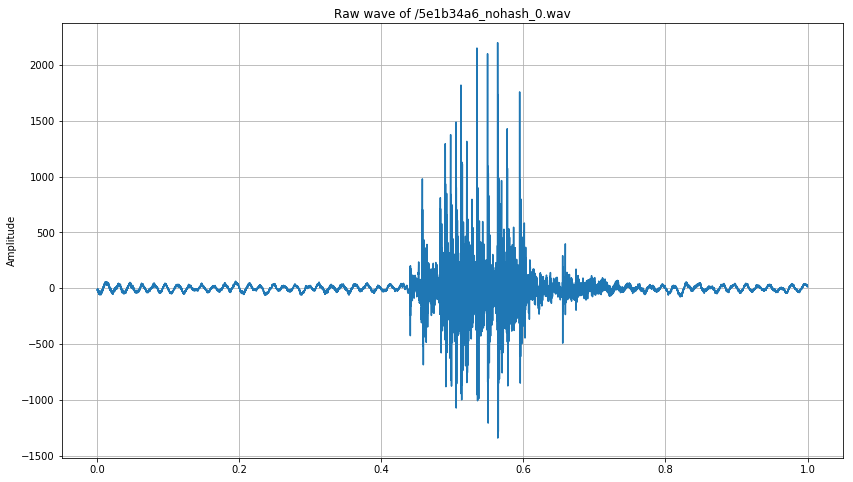

In [5]:
fig = plt.figure(figsize=(14, 8))
plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
plt.gca().set_title('Raw wave of ' + filename)
plt.gca().set_ylabel('Amplitude')
plt.grid("on")

## 1.2 Log Spectrogram

The same speech signal could be interpreted as made up of several frequencies of waves. A visualization of the power, i.e. energy per unit time in each frequency v/s time is called the Spectrogram.

Usually, the log of this energy is considered a better parameter. This is because the power in sound is synonymous with volume (loudness) of the sound, and the human ears are more sensitive to smaller volumes than larger volumes. So it is more convenient to observe the log of the volume rather than the volume itself. The log of sound power is measured in deciBels (dB). (You might be familiar with dB as a unit of sound volume). Hence, we shall consider the Log Spectrogram instead of just the spectrogram.

Let us cmpute the Log Spectrogram of the audio file we read:

In [6]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    
    # Number of samples per window/segment
    nperseg = int(round(window_size * sample_rate / 1e3))
    
    # Number of overlapping samples
    noverlap = int(round(step_size * sample_rate / 1e3))
    
    # Compute the spectrogram
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    # Return log of the spectrogram values, with time axis in columns and frequencies in rows
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [7]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

Let us plot the log spectrogram:

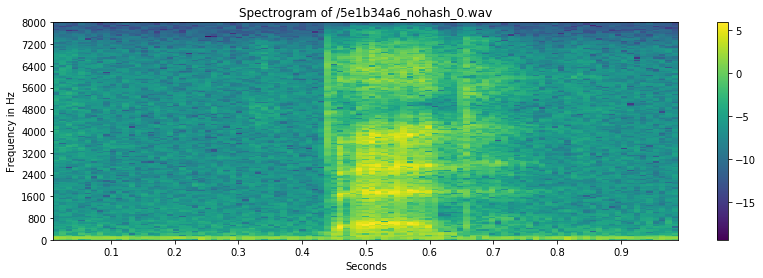

In [8]:
fig = plt.figure(figsize=(14, 4))
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.gca().set_yticks(freqs[::16])
plt.gca().set_xticks(times[9::10])
plt.gca().set_title('Spectrogram of ' + filename)
plt.gca().set_ylabel('Frequency in Hz')
plt.gca().set_xlabel('Seconds')
plt.colorbar()

As can be seen from the amplitude v/s time graph, the command is being uttered between 0.4 seconds and 0.6 seconds.

As can be seen from the spectrogram, the command is composed more of lower frequencies than higher frequencies. The rest of the time when there is no speech, each frequency has an equal contribution to the sound. This is called "White Noise".

Notice that the range of frequencies we are observing in the spectrogram is the linear scale between 0 Hz and 8000 Hz.

## 1.2. Mel Spectrogram

Human ears tend to listen to sounds in the log scale. That means, at lower frequencies we can detect small changes, but at higher frequencies our ears become less sensitive to small changes. For example, the difference between 10 Hz and 20 Hz would sound almost the same to us as that between 1000 Hz and 2000 Hz. To observe this logarithmic change, the frequency scale is modified into the ["mel frequency" scale](https://en.wikipedia.org/wiki/Mel_scale).

Let us compute the Mel Spectrogram using a convenient function in the `librosa` library in Python:

In [9]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, hop_length=int(0.020*sample_rate), n_mels=128)
print(S.shape)

(128, 51)


As mentioned before, the log of the spectrogram is a better parameter to observe rather than the spectrogram itself. Let us compute this using another convenient function in the `librosa` library:

In [10]:
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

Let's plot the log Mel spectrogam with the y-axis having frequenies in the mel scale instead of the linear scale: 

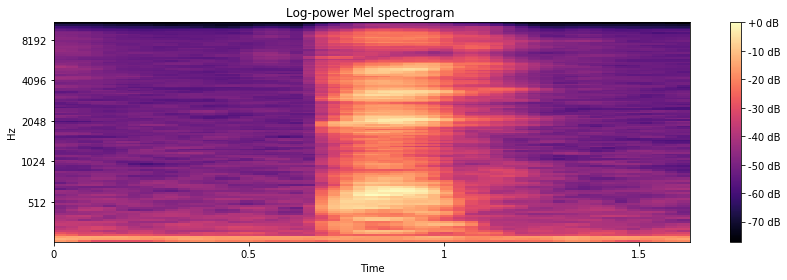

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Log-power Mel spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Observe that the frequencies in the y-axis are not linear in scale. 

## 1.3 Mel Frequency Cepstral Coefficients (MFCCs)

Next, "Cepstral Coefficients" are important numbers that describe speech information in audio. By computing these Cepstral Coefficients in the mel scale, we shall obtain Mel Frequency Cepstral Coefficients.

For technical details, the procedure to compute MFCCs is:

- Take the Discrete Fourier Transform on every sliding window over the audio with some overlap.
- Apply `n_mels` triangular Mel-scale filters onto the Fourier power spectrum, and apply logarithm to the outputs.
- Apply the Discrete Cosine Transform, and reduce dimensionality to `n_mfcc` dimensions.

Let's use a convenient library function called `librosa.feature.mfcc` to compute MFCCs from the spectrogram:

In [12]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
print(mfcc.shape)

(13, 51)


Let us plot the MFCCs:

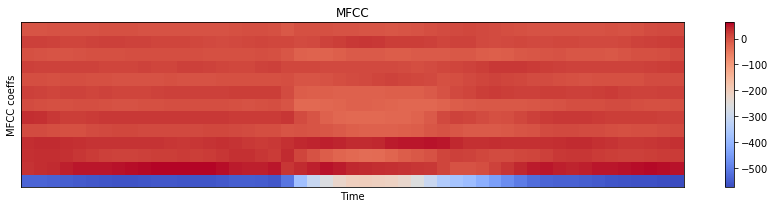

In [13]:
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 1.4 Delta MFCCs

MFCCs as such are quite powerful features, but even better features are their first-order and second-order derivatives.

Let's use a convenient library function called `librosa.feature.mfcc` to compute the second-order delta MFCCs:

In [14]:
# Find 1st order delta_mfcc
delta1_mfcc = librosa.feature.delta(mfcc, order=1)

# Find 2nd order delta_mfcc
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

Let's plot the 2nd order delta MFCCs:

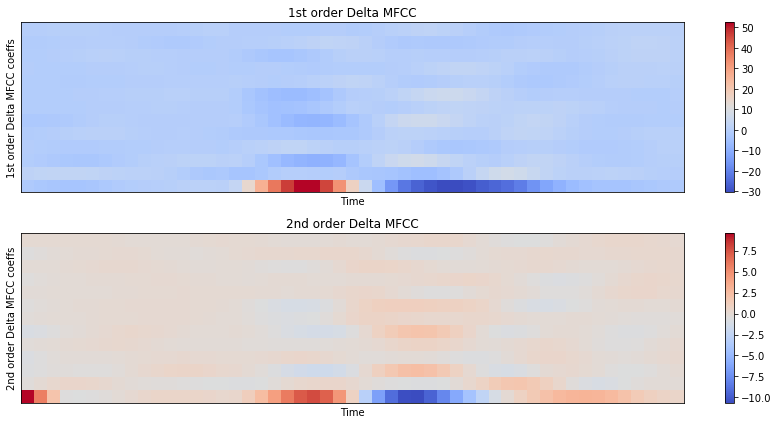

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
librosa.display.specshow(delta1_mfcc)
plt.ylabel('1st order Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('1st order Delta MFCC')
plt.colorbar()
plt.tight_layout()

plt.subplot(212)
librosa.display.specshow(delta2_mfcc)
plt.ylabel('2nd order Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('2nd order Delta MFCC')
plt.colorbar()
plt.tight_layout()

# 2. Load the Dataset
The dataset is of ~10GB in size and operating directly on it will take a lot of time, therefore we have included that as a Homework Exercise for those who are interested to go into that detail.
Our team has instead precomputed the features which can be loaded directly and computed on.

# 3. Load MFCC features

In [17]:
import scipy.io as sio
### Load MFCC Features
saved_vars = sio.loadmat('../../Datasets/audio/mfcc_feats/tf_speech_mfcc_31st_jan18.mat')
# print(saved_vars.keys())

mfcc_features_train = saved_vars['mfcc_features_train']
mfcc_labels_train = saved_vars['mfcc_labels_train']

mfcc_features_val = saved_vars['mfcc_features_val']
mfcc_labels_val = saved_vars['mfcc_labels_val']
print(mfcc_features_train.shape,mfcc_features_val.shape)

(57923, 416) (6798, 416)


# 4. Load Deep Features

In [19]:
deep_features_train = np.squeeze(np.load('../../Datasets/audio/deep_feats/train_set.npz'))
deep_labels_train = np.load('../../Datasets/audio/deep_feats/train_labs.npz')
deep_features_val = np.squeeze(np.load('../../Datasets/audio/deep_feats/validation_set.npz'))
deep_labels_val = np.load('../../Datasets/audio/deep_feats/validation_labs.npz')
print(deep_features_train.shape, deep_features_val.shape)

(63715, 4096) (7477, 4096)


# 5. Validation

We want to choose the best model for speech classification among:

- kNN classifier with MFCC features

- kNN classifier with Deep features

- Naive Bayes classifier with MFCC features

- Naive Bayes classifier with Deep features

- Multi-class Linear classifier with MFCC features

- Multi-class Linear classifier with Deep features

To do that, let's find the validation accuracies of each method using MFCC features and deep features.

We shall use our familiar convenient function to choose an algorithm, train on training features and labels as inputs, and obtain accuracy on given features and labels.

## Function to choose algorithm, features and labels to get accuracy

We created a convenient function to which you can choose the algorithm you want to use - `'kNN'`, `'NB'` (Naive Bayes), or `'linear'` (multiclass linear classifier) - and input features and labels for training and validation/testing:

**`acc = predict_and_find_accuracy(algorithm, train_features, train_labels, given_features, given_labels, k)`**

INPUTS:

- **`algorithm`** is one of `'kNN'`, `'NB'` (Naive Bayes), and `'linear'`,


- **`train_features`** are either `mfcc_features_train` or `deep_features_train`,


- **`train_labels`** are either `mfcc_labels_train` or `deep_labels_train`,


- **`given_features`** are `XXX_features_val` in case of validation, and `XXX_features_test` in case of testing (`XXX` being either `mfcc` or `deep` depending on what you chose to train the model on),


- **`given_labels`** are `XXX_features_val` in case of validation, and `XXX_features_test` in case of testing (`XXX` being either `mfcc` or `deep` depending on what you chose to train the model on),


- **`k`** is the value of $k$ to be used _in case_ we are using kNN classifier.

OUTPUT:

- **acc** is the accuracy of the `algorithm` on `given_features` & `given_labels` after being trained on `train_features` & `train_labels`.

## 5.1. kNN Classifier

We want to choose the value of $k$ based on validation accuracy. Choose $k$ among 1, 3, 7, 15, 51, 101.

In [20]:
values_of_k = [1, 3, 7, 15, 51, 101]

## 5.1.1. kNN with MFCC features

**Exercise 1: Find the best $k$ using validation accuracy on MFCC features**

In [ ]:
# Your code here

mfcc_k_acc = []

for k in values_of_k:
    mfcc_k_acc.append(predict_and_find_accuracy("kNN", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val, k))
    
best_k_mfcc = values_of_k[np.argmax(mfcc_k_acc)]
print(best_k_mfcc)

In [ ]:
print(best_k_mfcc)

**Exercise 2: Find the validation accuracy of kNN classifier on MFCC features using best $k$**

In [ ]:
kNN_mfcc_val_acc = predict_and_find_accuracy("kNN", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val, best_k_mfcc)
print(kNN_mfcc_val_acc)

## 5.1.2. kNN with Deep features

**Exercise 3: Find the best $k$ using validation accuracy on Deep features**

In [ ]:
# Your code here
????????????

best_k_deep = ????????

In [ ]:
print(best_k_deep)

**Exercise 4: Find the validation accuracy of kNN classifier on Deep features using best $k$**

In [ ]:
kNN_deep_val_acc = ????????
print(kNN_deep_val_acc)

## 5.2 Naive Bayes classifier

Find the validation accuracies with MFCC features and Deep features using Naive Bayes classifier.

**Exercise 5: Find the validation accuracy of Naive Bayes classifier on MFCC features**

In [ ]:
NB_mfcc_val_acc = ????????
print(NB_mfcc_val_acc)

**Exercise 6: Find the validation accuracy of Naive Bayes classifier on deep features**

In [ ]:
NB_deep_val_acc = ????????
print(NB_deep_val_acc)

## 5.3 Multi-class linear classifier

Find the validation accuracies with MFCC features and Deep features using Multi-class linear classifier.

**Exercise 7: Find the validation accuracy of Multi-class linear classifier on MFCC features**

In [ ]:
linear_mfcc_val_acc = ????????
print(linear_mfcc_val_acc)

**Exercise 8: Find the validation accuracy of Multi-class linear classifier on Deep features**

In [ ]:
linear_deep_val_acc = ????????
print(linear_deep_val_acc)

## 5.4 Choose best model

Let us compare the validation accuracies of each model:

In [ ]:
print("      Model                       Val acc ")
print("------------------------------------------")
print("kNN with MFCC features         :   ", "{0:.03f}".format(kNN_mfcc_val_acc))
print("kNN with Deep features         :   ", "{0:.03f}".format(kNN_deep_val_acc))
print("Naive Bayes with MFCC features :   ", "{0:.03f}".format(NB_mfcc_val_acc))
print("Naive Bayes with Deep features :   ", "{0:.03f}".format(NB_deep_val_acc))
print("Linear with MFCC features      :   ", "{0:.03f}".format(linear_mfcc_val_acc))
print("Linear with Deep features      :   ", "{0:.03f}".format(linear_deep_val_acc))

**Exercise 9: Which is the best model among the above 6 based on their validation accuracies?**

# 6. Testing

**Exercise 10: Find the testing accuracies.**

In [ ]:
# Finding Testing accuracies
NB_mfcc_test_acc = ????????
NB_deep_test_acc = ????????
kNN_mfcc_test_acc = ????????
kNN_deep_test_acc = ????????
linear_mfcc_test_acc = ????????
linear_deep_test_acc = ????????

Comparing the validation and testing accuracies:

In [ ]:
print("      Model                       Val acc      Test acc ")
print("--------------------------------------------------------")
print("kNN with MFCC features         :   ", "{0:.03f}".format(kNN_mfcc_val_acc), "      ", "{0:.03f}".format(kNN_mfcc_test_acc))
print("kNN with Deep features         :   ", "{0:.03f}".format(kNN_deep_val_acc), "      ", "{0:.03f}".format(kNN_deep_test_acc))
print("Naive Bayes with MFCC features :   ", "{0:.03f}".format(NB_mfcc_val_acc), "      ", "{0:.03f}".format(NB_mfcc_test_acc))
print("Naive Bayes with Deep features :   ", "{0:.03f}".format(NB_deep_val_acc), "      ", "{0:.03f}".format(NB_deep_test_acc))
print("Linear with MFCC features      :   ", "{0:.03f}".format(linear_mfcc_val_acc), "      ", "{0:.03f}".format(linear_mfcc_test_acc))
print("Linear with Deep features      :   ", "{0:.03f}".format(linear_deep_val_acc), "      ", "{0:.03f}".format(linear_deep_test_acc))

**Do the validation accuracies estimate the testing accuracies well?**

# SOLUTIONS

# Exercise 1

In [ ]:
mfcc_k_acc = []

for k in values_of_k:
    mfcc_k_acc.append(predict_and_find_accuracy("kNN", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val, k))
    
best_k_mfcc = values_of_k[np.argmax(mfcc_k_acc)]
print(best_k_mfcc)

# Exercise 2

In [ ]:
kNN_mfcc_val_acc = predict_and_find_accuracy("kNN", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val, best_k_mfcc)
print(kNN_mfcc_val_acc)

# Exercise 3

In [ ]:
deep_k_acc = []

for k in values_of_k:
    deep_k_acc.append(predict_and_find_accuracy("kNN", deep_features_train, deep_labels_train, deep_features_val, deep_labels_val, k))
    
best_k_deep = values_of_k[np.argmax(deep_k_acc)]
print(best_k_deep)

# Exercise 4

In [ ]:
kNN_deep_val_acc = predict_and_find_accuracy("kNN", deep_features_train, deep_labels_train, deep_features_val, deep_labels_val, best_k_deep)
print(kNN_deep_val_acc)

# Exercise 5

In [ ]:
NB_mfcc_val_acc = predict_and_find_accuracy("NB", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val)
print(NB_mfcc_val_acc)

# Exercise 6

In [ ]:
NB_deep_val_acc = predict_and_find_accuracy("NB", deep_features_train, deep_labels_train, deep_features_val, deep_labels_val)
print(NB_deep_val_acc)

# Exercise 7

In [ ]:
linear_mfcc_val_acc = predict_and_find_accuracy("linear", mfcc_features_train, mfcc_labels_train, mfcc_features_val, mfcc_labels_val)
print(linear_mfcc_val_acc)

# Exercise 8

In [ ]:
linear_deep_val_acc = predict_and_find_accuracy("linear", deep_features_train, deep_labels_train, deep_features_val, deep_labels_val)
print(linear_deep_val_acc)

# Exercise 9

In [ ]:
????????????????

# Exercise 10

In [ ]:
# Finding Testing accuracies
NB_mfcc_test_acc = predict_and_find_accuracy("NB", mfcc_features_train, mfcc_labels_train, mfcc_features_test, mfcc_labels_test)
NB_deep_test_acc = predict_and_find_accuracy("NB", deep_features_train, deep_labels_train, deep_features_test, deep_labels_test)
kNN_mfcc_test_acc = predict_and_find_accuracy("kNN", mfcc_features_train, mfcc_labels_train, mfcc_features_test, mfcc_labels_test)
kNN_deep_test_acc = predict_and_find_accuracy("kNN", deep_features_train, deep_labels_train, deep_features_test, deep_labels_test)
linear_mfcc_test_acc = predict_and_find_accuracy("linear", mfcc_features_train, mfcc_labels_train, mfcc_features_test, mfcc_labels_test)
linear_deep_test_acc = predict_and_find_accuracy("linear", deep_features_train, deep_labels_train, deep_features_test, deep_labels_test)